In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import seaborn as sns

from adaptive_time.utils import set_directory_in_project

from importlib import reload
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

from pprint import pprint

sns.set_style("darkgrid")
sns.set_palette("colorblind")

In [2]:
from adaptive_time import plot_utils
from adaptive_time import utils
from adaptive_time import run_lib
from adaptive_time import value_est
from adaptive_time.value_est import approx_integrators

approx_integrators = reload(approx_integrators)
run_lib = reload(run_lib)
value_est = reload(value_est)
plot_utils = reload(plot_utils)
utils = reload(utils)

In [3]:
set_directory_in_project()
data_dir = "./data"
env_names = [env_name for env_name in os.listdir(data_dir) if not env_name.startswith(".DS_Store")]
print(env_names)

Changed working directory to /home/bryanpu1/projects/adaptive_time
['hopper-v3', 'swimmer-v3', 'pusher-v2', 'cheetah-v3', 'inverted_double_pendulum-v2', 'ant-v3']


In [4]:
prefixes = ["uniform", "adaptive"]

agg_results_per_prefix = {}
samplers_per_prefix = {}
for prefix in prefixes:
    if prefix == "uniform":
        sampler_constructor = approx_integrators.UniformlySpacedIntegrator
    elif prefix == "adaptive":
        sampler_constructor = approx_integrators.AdaptiveQuadratureIntegrator
    else:
        raise NotImplementedError
    agg_results_per_prefix[prefix] = pickle.load(open("./{}-combined_mujoco_val_est.pkl".format(prefix), "rb"))
    samplers_per_prefix[prefix] = {
        hyperparam: sampler_constructor(hyperparam) for hyperparam in agg_results_per_prefix[prefix]["ant-v3"]["approx_integrals"]
    }

# Sample trajectories and estimate values

In [5]:
update_budget = 1_000_000
sample_block = 1_000_000
num_seeds = 10

est_results = {}

for prefix, agg_results in agg_results_per_prefix.items():
    print(prefix)
    est_results[prefix] = {}
    samplers_tried = samplers_per_prefix[prefix]

    for env_name in agg_results:
        vals_per_state = np.concatenate(
            [np.sum(np.load(reward_file).T, axis=-1) for reward_file in agg_results[env_name]["reward_file"]]
        )
        print(vals_per_state.shape)

        approx_integrals = agg_results[env_name]["approx_integrals"]
        num_pivots = agg_results[env_name]["num_pivots"]

        weights = np.ones(len(vals_per_state)) / len(vals_per_state)
        true_value = np.sum(weights * vals_per_state)

        est_results[prefix][env_name] = {
            "weights": weights,
            "true_value": true_value,
            "runs": []
        }

        for seed in tqdm(range(num_seeds)):
            estimated_values_by_episode = {}
            number_of_pivots_by_episode = {}
            all_values_by_episode = {}

            rng = np.random.RandomState(seed)
            start_states = rng.choice(len(vals_per_state), p=weights, size=(update_budget))

            for sampler_name, sampler in samplers_tried.items():
                # print("sampler_name:", sampler_name)
                # Update the value estimate with new samples until we run out of budget.
                used_updates = 0
                value_estimate = 0
                num_episodes = 0
                all_values_by_episode[sampler_name] = []

                estimated_values_by_episode[sampler_name] = []
                number_of_pivots_by_episode[sampler_name] = []

                # pbar = tqdm(total = update_budget)
                while used_updates < update_budget:
                    num_episodes += 1
                    if num_episodes % sample_block == 0:
                        start_states = rng.choice(len(vals_per_state), p=weights, size=(update_budget))
                    start_state = start_states[(num_episodes - 1) % sample_block]
                    val_sample = approx_integrals[sampler_name][start_state]
                    all_values_by_episode[sampler_name].append(val_sample)
                    
                    value_estimate += (1.0/num_episodes) * (val_sample - value_estimate)
                    used_updates += num_pivots[sampler_name][start_state]

                    estimated_values_by_episode[sampler_name].append(value_estimate)
                    number_of_pivots_by_episode[sampler_name].append(used_updates)
                #     pbar.update(num_pivots[sampler_name][start_state])
                # pbar.close()
            est_results[prefix][env_name]["runs"].append({
                "estimated_values_by_episode": estimated_values_by_episode,
                "number_of_pivots_by_episode": number_of_pivots_by_episode,
                "all_values_by_episode": all_values_by_episode,
            })


uniform
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

adaptive
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

# Compile plot statistics using interpolation

In [6]:
def process_across_runs(
    runs,
    samplers_tried,
    true_value,
):
    results = {}
    for sampler in samplers_tried:
        interpolated_results = np.zeros((len(runs), update_budget + 1))
        for run_i, run in enumerate(runs):
            number_of_pivots_by_episode = run["number_of_pivots_by_episode"][sampler]
            estimated_values_by_episode = run["estimated_values_by_episode"][sampler]

            interpolated_results[run_i] = np.interp(
                np.arange(update_budget + 1),
                number_of_pivots_by_episode,
                np.abs(estimated_values_by_episode - true_value)[:number_of_pivots_by_episode[-1]]
            )
        results[sampler] = interpolated_results
    return results

In [7]:

plot_stats = {}
for prefix, curr_result in est_results.items():
    print(prefix)
    samplers_tried = samplers_per_prefix[prefix]
    plot_stats[prefix] = {}
    for env_i, env_name in enumerate(tqdm(curr_result)):
        true_value = curr_result[env_name]["true_value"]
        env_result = process_across_runs(
            curr_result[env_name]["runs"],
            samplers_tried,
            true_value
        )
        plot_stats[prefix][env_name] = env_result

uniform


  0%|          | 0/6 [00:00<?, ?it/s]

adaptive


  0%|          | 0/6 [00:00<?, ?it/s]

# Plot error vs number of updates

## Plot aggregated result

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

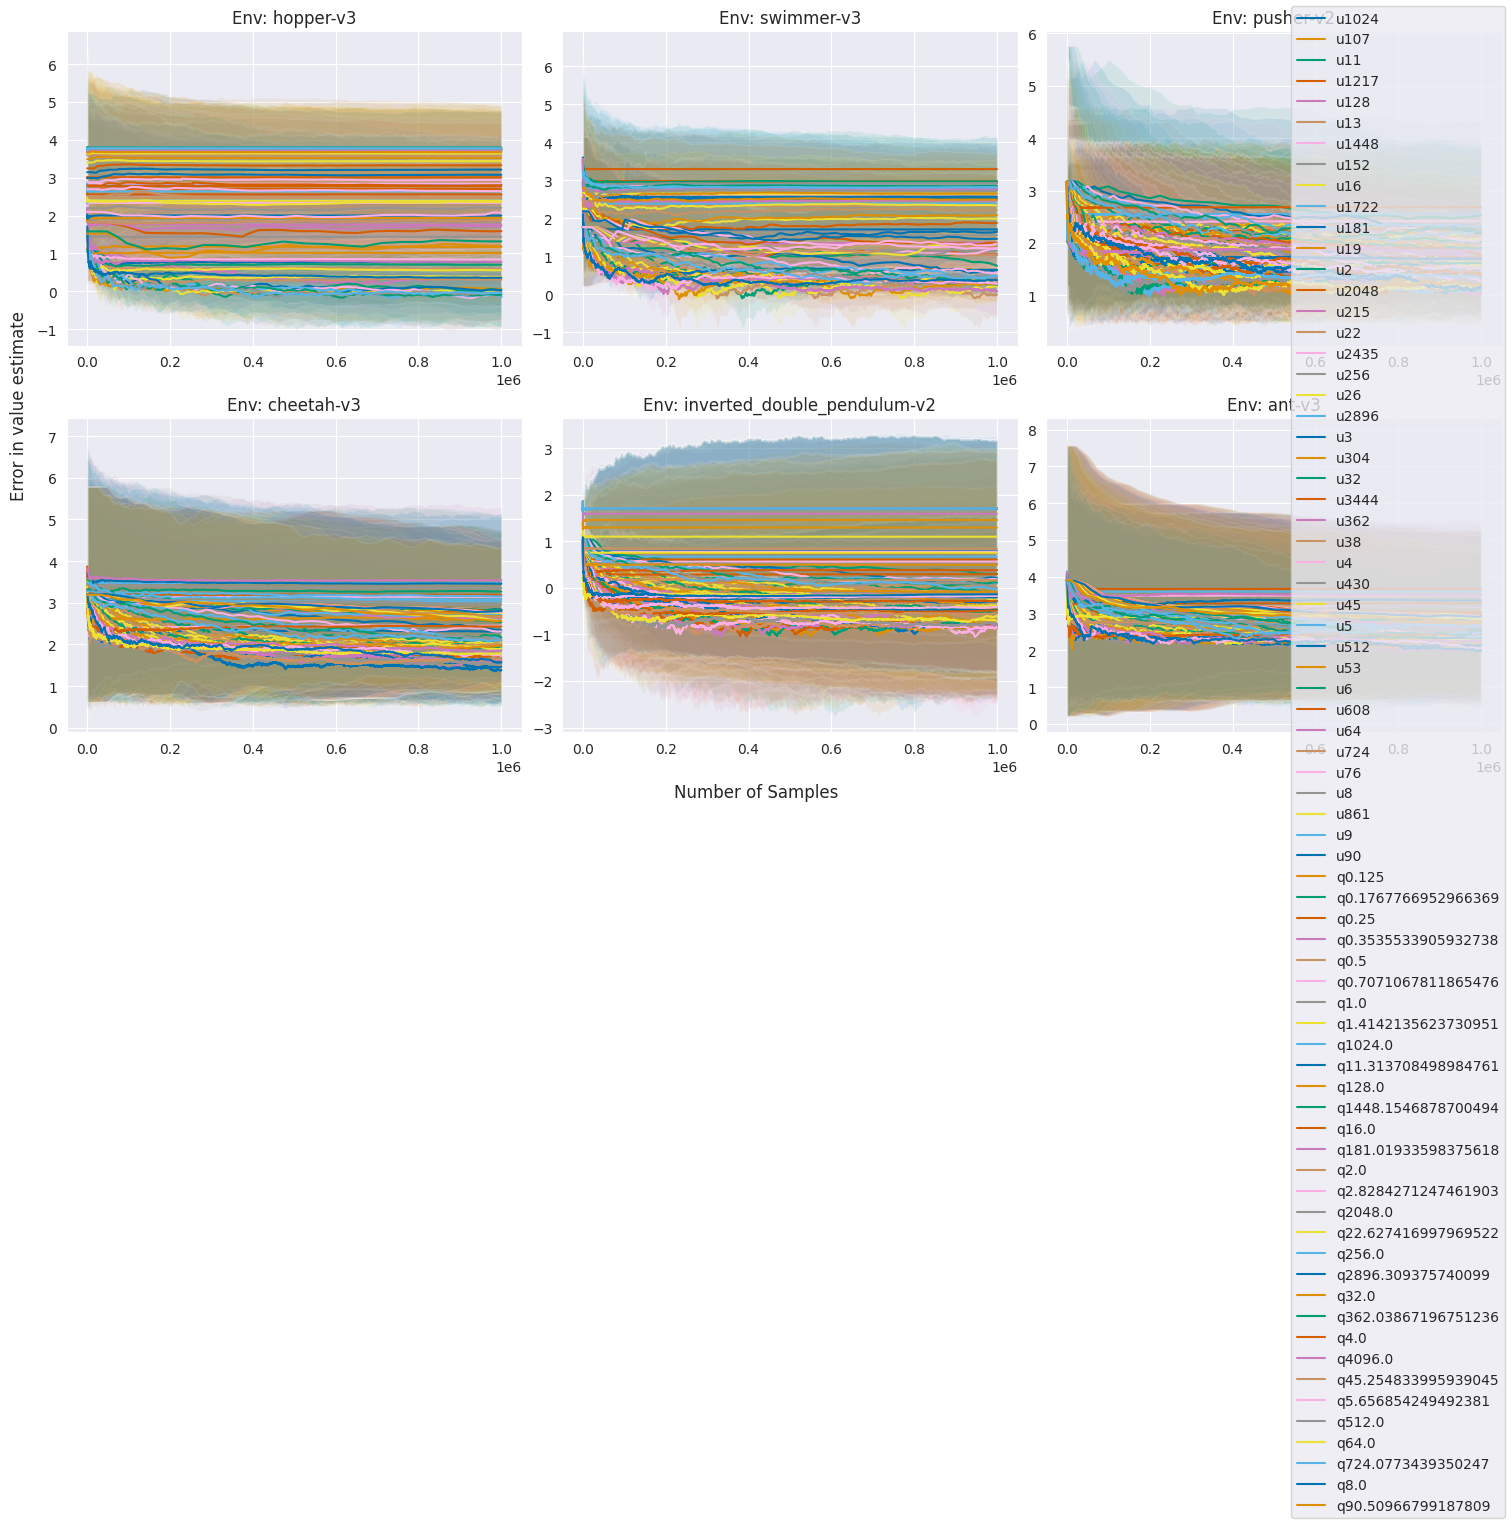

In [8]:
# s_to_plot = ["q1", "q10", "q100", "u1", "u10", "u500"]
# s_to_plot = ["q0", "u1"]
# s_to_plot = samplers_tried.keys()

ncols = 3
fig, axes = plt.subplots(nrows=len(env_names) // ncols, ncols=ncols, figsize=(15, 8), layout="constrained")

start_idx = 0
end_idx = 1_000_000
for env_i, env_name in enumerate(env_names):
    ax = axes[env_i // ncols, env_i % ncols]
    for prefix in prefixes:
        env_result = plot_stats[prefix][env_name]
        samplers_tried = samplers_per_prefix[prefix]
        for s in tqdm(samplers_tried):
            y_means = np.nanmean(env_result[s][:, start_idx:end_idx], axis=0)
            y_stderrs = np.nanstd(env_result[s][:, start_idx:end_idx], axis=0) / np.sqrt(num_seeds)
            x_range = np.arange(update_budget + 1)[start_idx:end_idx]

            y_means = np.log10(y_means, out=np.zeros_like(y_means), where=(y_means != 0))
            y_stderrs = np.log10(y_stderrs, out=np.zeros_like(y_stderrs), where=(y_stderrs != 0))

            ax.plot(
                x_range,
                y_means,
                label=s if env_i == 0 else ""
            )
            ax.fill_between(
                x_range,
                (y_means - y_stderrs),
                (y_means + y_stderrs),
                alpha=0.1
            )
    ax.set_title("Env: {}".format(env_name))

fig.supylabel("Error in value estimate")
fig.supxlabel("Number of Samples")
fig.legend()
plt.show()

# Plot error vs hyperparameter (i.e. tolerance/discretization)

In [9]:
budgets_to_check_per_env = {
    "inverted_double_pendulum-v2": 25000 * np.array([2, 5, 10, 20, 40]),
    "swimmer-v3": 20000 * np.array([2, 5, 10, 20, 40]),
    "hopper-v3": 8000 * np.array([2, 5, 10, 20, 40]),
    "ant-v3": 25000 * np.array([2, 5, 10, 20, 40]),
    "cheetah-v3": 25000 * np.array([2, 5, 10, 20, 40]),
    "pusher-v2": 25000 * np.array([2, 5, 10, 20, 40]),
    
}

# Approximate horizon for adaptive method for "same mapping"

In [10]:
print(agg_results.keys())

dict_keys(['inverted_double_pendulum-v2', 'swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'pusher-v2'])


In [18]:

adaptive_checkpoint = "./adaptive-combined_mujoco_val_est.pkl"
adaptive_results = pickle.load(open(adaptive_checkpoint, "rb"))

tolerances = np.power(10, np.arange(-2.0, 4.0, 1.0)) * 5
samplers_tried = {
    "q{}".format(tolerance): approx_integrators.AdaptiveQuadratureIntegrator(tolerance=tolerance) for tolerance in tolerances
}

tau_to_h = {}
for env_i, env_name in enumerate(env_names):
    traj_len = 40000 if env_name == "swimer-v3" else 50000
    env_result = plot_stats["adaptive"][env_name]
    num_pivots = agg_results_per_prefix["adaptive"][env_name]["num_pivots"]
    tau_to_h[env_name] = np.array([
        (sampler, math.ceil(traj_len / np.mean(num_pivots[sampler]))) for sampler in num_pivots
    ])

[ 16000  40000  80000 160000 320000]
[['u2' 'u3' 'u4' 'u5' 'u6' 'u8' 'u9' 'u11' 'u13' 'u16' 'u19' 'u22' 'u26'
  'u32' 'u38' 'u45' 'u53' 'u64' 'u76' 'u90' 'u107' 'u128' 'u152' 'u181'
  'u215' 'u256' 'u304' 'u362' 'u430' 'u512' 'u608' 'u724' 'u861' 'u1024'
  'u1217' 'u1448' 'u1722' 'u2048' 'u2435' 'u2896' 'u3444']
 ['2' '3' '4' '5' '6' '8' '9' '11' '13' '16' '19' '22' '26' '32' '38'
  '45' '53' '64' '76' '90' '107' '128' '152' '181' '215' '256' '304'
  '362' '430' '512' '608' '724' '861' '1024' '1217' '1448' '1722' '2048'
  '2435' '2896' '3444']]


  0%|          | 0/5 [00:00<?, ?it/s]

[ 16000  40000  80000 160000 320000]
[['q0.125' 'q4.0' 'q2.0' 'q1.4142135623730951' 'q1.0'
  'q2.8284271247461903' 'q0.5' 'q0.3535533905932738'
  'q0.1767766952966369' 'q0.25' 'q0.7071067811865476'
  'q5.656854249492381' 'q8.0' 'q11.313708498984761' 'q16.0'
  'q22.627416997969522' 'q32.0' 'q45.254833995939045' 'q64.0'
  'q90.50966799187809' 'q128.0' 'q181.01933598375618' 'q256.0'
  'q362.03867196751236' 'q512.0' 'q724.0773439350247' 'q1024.0'
  'q1448.1546878700494' 'q2048.0' 'q2896.309375740099' 'q4096.0']
 ['2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '3' '3' '4' '4' '6' '8'
  '12' '18' '29' '51' '95' '183' '373' '803' '1795' '6199' '9557' '11390'
  '13671' '16130']]


  0%|          | 0/5 [00:00<?, ?it/s]

[ 40000 100000 200000 400000 800000]
[['u2' 'u3' 'u4' 'u5' 'u6' 'u8' 'u9' 'u11' 'u13' 'u16' 'u19' 'u22' 'u26'
  'u32' 'u38' 'u45' 'u53' 'u64' 'u76' 'u90' 'u107' 'u128' 'u152' 'u181'
  'u215' 'u256' 'u304' 'u362' 'u430' 'u512' 'u608' 'u724' 'u861' 'u1024'
  'u1217' 'u1448' 'u1722' 'u2048' 'u2435' 'u2896' 'u3444']
 ['2' '3' '4' '5' '6' '8' '9' '11' '13' '16' '19' '22' '26' '32' '38'
  '45' '53' '64' '76' '90' '107' '128' '152' '181' '215' '256' '304'
  '362' '430' '512' '608' '724' '861' '1024' '1217' '1448' '1722' '2048'
  '2435' '2896' '3444']]


  0%|          | 0/5 [00:00<?, ?it/s]

[ 40000 100000 200000 400000 800000]
[['q0.125' 'q0.1767766952966369' 'q0.25' 'q0.3535533905932738' 'q0.5'
  'q0.7071067811865476' 'q1.0' 'q1.4142135623730951' 'q4.0' 'q2.0'
  'q2.8284271247461903' 'q8.0' 'q5.656854249492381' 'q11.313708498984761'
  'q16.0' 'q22.627416997969522' 'q32.0' 'q45.254833995939045' 'q64.0'
  'q90.50966799187809' 'q128.0' 'q181.01933598375618' 'q256.0'
  'q362.03867196751236' 'q512.0' 'q724.0773439350247' 'q1024.0'
  'q1448.1546878700494' 'q2048.0' 'q2896.309375740099' 'q4096.0']
 ['2' '2' '2' '2' '2' '2' '2' '2' '3' '3' '3' '4' '4' '5' '6' '7' '8'
  '10' '12' '14' '17' '22' '29' '37' '50' '75' '133' '285' '609' '1225'
  '2378']]


  0%|          | 0/5 [00:00<?, ?it/s]

[  50000  125000  250000  500000 1000000]
[['u2' 'u3' 'u4' 'u5' 'u6' 'u8' 'u9' 'u11' 'u13' 'u16' 'u19' 'u22' 'u26'
  'u32' 'u38' 'u45' 'u53' 'u64' 'u76' 'u90' 'u107' 'u128' 'u152' 'u181'
  'u215' 'u256' 'u304' 'u362' 'u430' 'u512' 'u608' 'u724' 'u861' 'u1024'
  'u1217' 'u1448' 'u1722' 'u2048' 'u2435' 'u2896' 'u3444']
 ['2' '3' '4' '5' '6' '8' '9' '11' '13' '16' '19' '22' '26' '32' '38'
  '45' '53' '64' '76' '90' '107' '128' '152' '181' '215' '256' '304'
  '362' '430' '512' '608' '724' '861' '1024' '1217' '1448' '1722' '2048'
  '2435' '2896' '3444']]


  0%|          | 0/5 [00:00<?, ?it/s]

[  50000  125000  250000  500000 1000000]
[['q0.125' 'q0.1767766952966369' 'q0.25' 'q0.3535533905932738' 'q0.5'
  'q0.7071067811865476' 'q1.0' 'q1.4142135623730951' 'q2.0'
  'q2.8284271247461903' 'q4.0' 'q5.656854249492381' 'q8.0'
  'q11.313708498984761' 'q16.0' 'q22.627416997969522' 'q32.0'
  'q45.254833995939045' 'q64.0' 'q90.50966799187809' 'q128.0'
  'q181.01933598375618' 'q256.0' 'q362.03867196751236' 'q512.0'
  'q724.0773439350247' 'q1024.0' 'q1448.1546878700494' 'q2048.0'
  'q2896.309375740099' 'q4096.0']
 ['45' '51' '59' '69' '80' '94' '111' '131' '154' '184' '219' '262' '312'
  '374' '447' '536' '635' '756' '901' '1067' '1240' '1467' '1698' '1913'
  '2129' '2573' '3091' '3560' '3781' '3864' '4087']]


  0%|          | 0/5 [00:00<?, ?it/s]

[  50000  125000  250000  500000 1000000]
[['u2' 'u3' 'u4' 'u5' 'u6' 'u8' 'u9' 'u11' 'u13' 'u16' 'u19' 'u22' 'u26'
  'u32' 'u38' 'u45' 'u53' 'u64' 'u76' 'u90' 'u107' 'u128' 'u152' 'u181'
  'u215' 'u256' 'u304' 'u362' 'u430' 'u512' 'u608' 'u724' 'u861' 'u1024'
  'u1217' 'u1448' 'u1722' 'u2048' 'u2435' 'u2896' 'u3444']
 ['2' '3' '4' '5' '6' '8' '9' '11' '13' '16' '19' '22' '26' '32' '38'
  '45' '53' '64' '76' '90' '107' '128' '152' '181' '215' '256' '304'
  '362' '430' '512' '608' '724' '861' '1024' '1217' '1448' '1722' '2048'
  '2435' '2896' '3444']]


  0%|          | 0/5 [00:00<?, ?it/s]

[  50000  125000  250000  500000 1000000]
[['q0.125' 'q64.0' 'q5.656854249492381' 'q45.254833995939045' 'q4.0'
  'q32.0' 'q22.627416997969522' 'q8.0' 'q2.0' 'q16.0'
  'q2.8284271247461903' 'q0.7071067811865476' 'q11.313708498984761'
  'q0.1767766952966369' 'q0.25' 'q1.4142135623730951'
  'q0.3535533905932738' 'q1.0' 'q0.5' 'q128.0' 'q90.50966799187809'
  'q181.01933598375618' 'q256.0' 'q362.03867196751236' 'q512.0'
  'q724.0773439350247' 'q1024.0' 'q1448.1546878700494' 'q2048.0'
  'q2896.309375740099' 'q4096.0']
 ['2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
  '2' '3' '3' '3' '4' '5' '6' '8' '10' '14' '21' '34' '61']]


  0%|          | 0/5 [00:00<?, ?it/s]

[  50000  125000  250000  500000 1000000]
[['u2' 'u3' 'u4' 'u5' 'u6' 'u8' 'u9' 'u11' 'u13' 'u16' 'u19' 'u22' 'u26'
  'u32' 'u38' 'u45' 'u53' 'u64' 'u76' 'u90' 'u107' 'u128' 'u152' 'u181'
  'u215' 'u256' 'u304' 'u362' 'u430' 'u512' 'u608' 'u724' 'u861' 'u1024'
  'u1217' 'u1448' 'u1722' 'u2048' 'u2435' 'u2896' 'u3444']
 ['2' '3' '4' '5' '6' '8' '9' '11' '13' '16' '19' '22' '26' '32' '38'
  '45' '53' '64' '76' '90' '107' '128' '152' '181' '215' '256' '304'
  '362' '430' '512' '608' '724' '861' '1024' '1217' '1448' '1722' '2048'
  '2435' '2896' '3444']]


  0%|          | 0/5 [00:00<?, ?it/s]

[  50000  125000  250000  500000 1000000]
[['q0.125' 'q0.1767766952966369' 'q0.25' 'q0.3535533905932738' 'q0.5'
  'q0.7071067811865476' 'q1.0' 'q1.4142135623730951' 'q2.0'
  'q2.8284271247461903' 'q4.0' 'q5.656854249492381' 'q8.0'
  'q11.313708498984761' 'q16.0' 'q22.627416997969522' 'q32.0'
  'q45.254833995939045' 'q64.0' 'q90.50966799187809' 'q128.0'
  'q181.01933598375618' 'q256.0' 'q362.03867196751236' 'q2048.0'
  'q4096.0' 'q1024.0' 'q512.0' 'q1448.1546878700494' 'q724.0773439350247'
  'q2896.309375740099']
 ['131' '154' '182' '216' '258' '307' '367' '441' '533' '643' '785' '961'
  '1186' '1458' '1827' '2305' '3051' '4045' '5486' '7570' '10502' '13744'
  '16244' '16667' '16667' '16667' '16667' '16667' '16667' '16667' '16667']]


  0%|          | 0/5 [00:00<?, ?it/s]

[  50000  125000  250000  500000 1000000]
[['u2' 'u3' 'u4' 'u5' 'u6' 'u8' 'u9' 'u11' 'u13' 'u16' 'u19' 'u22' 'u26'
  'u32' 'u38' 'u45' 'u53' 'u64' 'u76' 'u90' 'u107' 'u128' 'u152' 'u181'
  'u215' 'u256' 'u304' 'u362' 'u430' 'u512' 'u608' 'u724' 'u861' 'u1024'
  'u1217' 'u1448' 'u1722' 'u2048' 'u2435' 'u2896' 'u3444']
 ['2' '3' '4' '5' '6' '8' '9' '11' '13' '16' '19' '22' '26' '32' '38'
  '45' '53' '64' '76' '90' '107' '128' '152' '181' '215' '256' '304'
  '362' '430' '512' '608' '724' '861' '1024' '1217' '1448' '1722' '2048'
  '2435' '2896' '3444']]


  0%|          | 0/5 [00:00<?, ?it/s]

[  50000  125000  250000  500000 1000000]
[['q0.125' 'q64.0' 'q5.656854249492381' 'q45.254833995939045' 'q4.0'
  'q32.0' 'q22.627416997969522' 'q8.0' 'q2.0' 'q16.0'
  'q2.8284271247461903' 'q0.7071067811865476' 'q11.313708498984761'
  'q0.1767766952966369' 'q0.25' 'q1.4142135623730951'
  'q0.3535533905932738' 'q1.0' 'q0.5' 'q128.0' 'q90.50966799187809'
  'q181.01933598375618' 'q256.0' 'q362.03867196751236' 'q512.0'
  'q724.0773439350247' 'q1024.0' 'q1448.1546878700494' 'q2048.0'
  'q2896.309375740099' 'q4096.0']
 ['2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2' '2'
  '2' '3' '3' '3' '4' '5' '6' '7' '10' '14' '21' '33' '57']]


  0%|          | 0/5 [00:00<?, ?it/s]

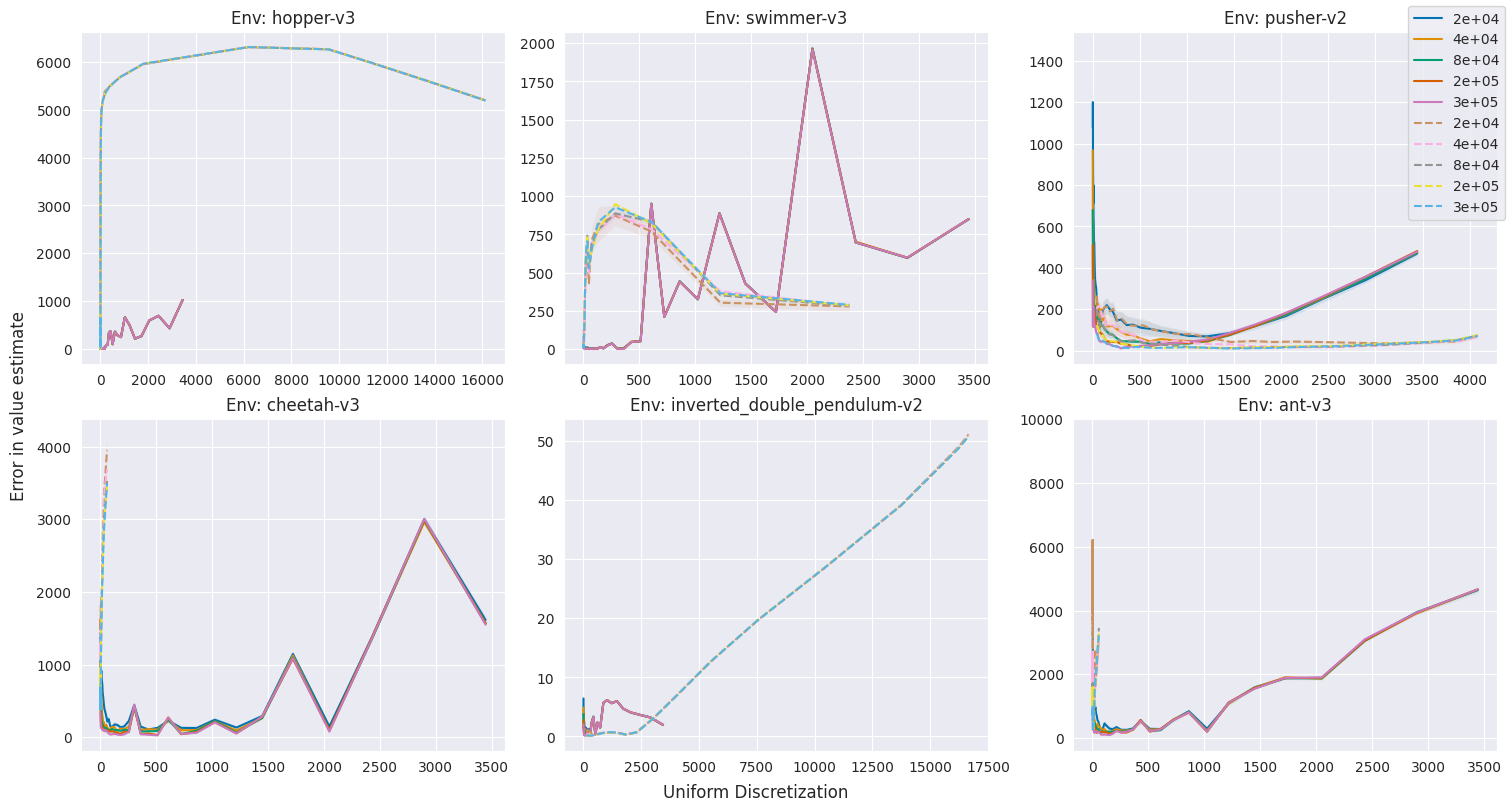

In [17]:
fig, axes = plt.subplots(nrows=len(env_names) // ncols, ncols=ncols, figsize=(15, 8), layout="constrained")

for env_i, env_name in enumerate(env_names):
    for prefix in prefixes:
    # for prefix in ["adaptive"]:
        if prefix == "uniform":
            spacing_keys = np.array(list(samplers_per_prefix["uniform"].keys()))
            spacing = np.array([int(key[1:]) for key in spacing_keys])
            sorted_idxes = np.argsort(spacing)
            sorted_spacing = spacing[sorted_idxes]
            sorted_keys = ["u{}".format(item) for item in sorted_spacing]
        elif prefix == "adaptive":
            sorted_idxes = np.argsort(tau_to_h[env_name][:, 1].astype(int))
            sorted_spacing = tau_to_h[env_name][:, 1][sorted_idxes].astype(int)
            sorted_keys = tau_to_h[env_name][:, 0][sorted_idxes]
        else:
            raise NotImplementedError

        env_result = plot_stats[prefix][env_name]
        ax = axes[env_i // ncols, env_i % ncols]

        budgets_to_check = budgets_to_check_per_env[env_name]
        print(budgets_to_check)
        print(np.vstack((sorted_keys, sorted_spacing)))
        for budget_to_check in tqdm(budgets_to_check):
            idx = int(budget_to_check)
            y_means = []
            y_stderrs = []
            for s in sorted_keys:
                y_means.append(np.nanmean(env_result[s][:, idx]))
                y_stderrs.append(np.nanstd(env_result[s][:, idx]) / np.sqrt(num_seeds))
            # y_means = np.log2(np.array(y_means))
            # y_stderrs = np.log2(np.array(y_stderrs))
                
            y_means = np.array(y_means)
            y_stderrs = np.array(y_stderrs)

            ax.plot(
                sorted_spacing,
                y_means,
                label="{:.0e}".format(idx) if env_i == 0 else "",
                linestyle="-" if prefix == "uniform" else "--"
            )
            ax.fill_between(
                sorted_spacing,
                (y_means - y_stderrs),
                (y_means + y_stderrs),
                alpha=0.1
            )
            ax.set_title("Env: {}".format(env_name))

fig.supylabel("Error in value estimate")
fig.supxlabel("Uniform Discretization")
fig.legend()
plt.show()